Arbetsprov

Bakgrund: OpenAlex är öppen datakälla med metadata om vetenskaplig publicering. Den innehåller
information från flera internationella databaser och består av flera hundra miljoner entiteter
(tidskriftsartiklar, bokkapitel, författare, organisationer, ämnesord, identifikatorer m.m.)
I dagsläget använder KIB licensierat metadata för att analysera Karolinska Institutets (KI)
vetenskapliga publicering utifrån olika parametrar. En öppen datakälla så som OpenAlex skulle
potentiellt kunna svara på samma frågor. Det finns ett strategiskt värde i att öppet kunna dela
resultat av den här typen av analyser. Vi vill därför utforska datats kvalitet och eventuella brister.
En grundförutsättning är att kunna identifiera publikationer som producerats av forskare verksamma
vid KI, dvs kunna knyta publikationer till KI som organisation.

OpenAlex:

Website: https://openalex.org/

Documentation: https://docs.openalex.org/

API: https://docs.openalex.org/api

Uppgift:

Hämta alla publikationer med unika DOI-nummer (identifikator för publikation) med författare
från Karolinska Institutet och Karolinska Universitetssjuhuset. Begränsa resultatet till att omfatta
publikationer av typen ’journal-article’ och publikationsår ’2020’. Följande information om varje
artikel ska hämtas:

• artikeltitel
• publiceringsdatum
• författare
• institution
• förlag

Organisera datat på ett överskådligt sätt
Du får använda valfritt programmeringsspråk för att lösa denna uppgift.
Vid presentationstillfället går vi tillsammans igenom koden och resonerar kring hur du har löst
uppgifterna.
Lycka till!

In [1]:
endpoint = 'works'

filters = ",".join((
    'institutions.ror:https://ror.org/056d84691',
    'institutions.ror:https://ror.org/00m8d6786',
    'type:journal-article', 
    'publication_year:2020',
    'has_doi:true',
))

# Karolinska Institute https://ror.org/056d84691
# Karolinska University Hospital https://ror.org/00m8d6786

In [2]:
import requests, json
import numpy as np
import math
import pandas as pd
import time
from collections import Counter
import matplotlib.pyplot as plt

In [3]:
def get_openalex_api_data(filters, endpoint, per_page=200):
    filtered_works_url = f'https://api.openalex.org/{endpoint}?per_page={per_page}&filter={filters}'
    response = requests.get(filtered_works_url)
    
    data = response.json()
    print(data['meta'])
    count = data['meta']['count']
    total_pages = math.ceil(count / data['meta']['per_page'])

    df = pd.DataFrame(data['results'])
    if(count > per_page):
        for i in range(2, total_pages+1):
            filtered_works_url_paged = f'https://api.openalex.org/{endpoint}?page={i}&per_page={per_page}&filter={filters}'
            response_page = requests.get(filtered_works_url_paged)
            data_page = response_page.json()
            print(data_page['meta'])
            df_temp = pd.DataFrame(data_page['results'])
            df = pd.concat([df, df_temp], ignore_index=True)
            time.sleep(1) # rate limiter cause I'm paranoid
    
    return df

def drop_unused(df, col):
    df = pd.DataFrame(df, columns=col)
    #TODO lots of magic strings here, maybe theres a better way
    df.head()
    df['ki_authors'] = ''
    df['ku_authors'] = ''
    df['other_authors'] = ''

    ku = 'Karolinska University Hospital'
    ki = 'Karolinska Institute'

    for i, r in df.iterrows():
        r['host_venue'] = r['host_venue']['publisher']
        author_list = r['authorships']
        author_list_clean_other = []
        author_list_clean_ki = []
        author_list_clean_ku = []
        for author in author_list:
            inst_clean = []
            for institution in author['institutions']:
                inst_clean.append(institution['display_name'])
            dict_author = {'name' : author['author']['display_name'],
                    'institutions' : inst_clean}
            if ki in dict_author['institutions']:
                author_list_clean_ki.append(dict_author)
            if ku in dict_author['institutions']:
                author_list_clean_ku.append(dict_author)
            if ki not in dict_author['institutions'] and ku not in dict_author['institutions']:
                author_list_clean_other.append(dict_author)
        r['other_authors'] = author_list_clean_other
        r['ki_authors'] = author_list_clean_ki
        r['ku_authors'] = author_list_clean_ku

    df.drop('authorships', axis=1, inplace=True)
    return df

In [4]:
temp_df = get_openalex_api_data(filters, endpoint)

{'count': 1439, 'db_response_time_ms': 165, 'page': 1, 'per_page': 200}
{'count': 1439, 'db_response_time_ms': 159, 'page': 2, 'per_page': 200}
{'count': 1439, 'db_response_time_ms': 120, 'page': 3, 'per_page': 200}
{'count': 1439, 'db_response_time_ms': 88, 'page': 4, 'per_page': 200}
{'count': 1439, 'db_response_time_ms': 91, 'page': 5, 'per_page': 200}
{'count': 1439, 'db_response_time_ms': 99, 'page': 6, 'per_page': 200}
{'count': 1439, 'db_response_time_ms': 129, 'page': 7, 'per_page': 200}
{'count': 1439, 'db_response_time_ms': 34, 'page': 8, 'per_page': 200}


In [5]:
pd.set_option('display.max_columns', None)
temp_df.head()

,id,doi,title,display_name,publication_year,publication_date,ids,host_venue,type,open_access,authorships,cited_by_count,biblio,is_retracted,is_paratext,concepts,mesh,alternate_host_venues,referenced_works,related_works,ngrams_url,abstract_inverted_index,cited_by_api_url,counts_by_year,updated_date,created_date
0,https://openalex.org/W3048775784,https://doi.org/10.1016/j.cell.2020.08.017,Robust T Cell Immunity in Convalescent Individ...,Robust T Cell Immunity in Convalescent Individ...,2020,2020-10-01,{'openalex': 'https://openalex.org/W3048775784...,"{'id': 'https://openalex.org/V110447773', 'iss...",journal-article,"{'is_oa': True, 'oa_status': 'hybrid', 'oa_url...","[{'author_position': 'first', 'author': {'id':...",1062,"{'volume': '183', 'issue': '1', 'first_page': ...",False,False,"[{'id': 'https://openalex.org/C2777910003', 'w...",[],"[{'id': 'https://openalex.org/V110447773', 'di...","[https://openalex.org/W1647345871, https://ope...","[https://openalex.org/W573847062, https://open...",https://api.openalex.org/works/W3048775784/ngrams,"{'<h2>Summary</h2>': [0], 'SARS-CoV-2-specific...",https://api.openalex.org/works?filter=cites:W3...,"[{'year': 2022, 'cited_by_count': 302}, {'year...",2022-09-24T04:56:51.047771,2020-08-18
1,https://openalex.org/W3083424448,https://doi.org/10.1016/j.cell.2020.09.016,The Immunology of Multisystem Inflammatory Syn...,The Immunology of Multisystem Inflammatory Syn...,2020,2020-11-12,{'openalex': 'https://openalex.org/W3083424448...,"{'id': 'https://openalex.org/V110447773', 'iss...",journal-article,"{'is_oa': True, 'oa_status': 'hybrid', 'oa_url...","[{'author_position': 'first', 'author': {'id':...",423,"{'volume': '183', 'issue': '4', 'first_page': ...",False,False,"[{'id': 'https://openalex.org/C203014093', 'wi...",[],"[{'id': 'https://openalex.org/V110447773', 'di...","[https://openalex.org/W1490176501, https://ope...","[https://openalex.org/W1538996288, https://ope...",https://api.openalex.org/works/W3083424448/ngrams,"{'<h2>Summary</h2>': [0], 'Severe': [1], 'acut...",https://api.openalex.org/works?filter=cites:W3...,"[{'year': 2022, 'cited_by_count': 134}, {'year...",2022-09-24T05:14:53.450417,2020-09-11
2,https://openalex.org/W2977883158,https://doi.org/10.1001/jamaneurol.2019.3365,Infection Risks Among Patients With Multiple S...,Infection Risks Among Patients With Multiple S...,2020,2020-02-01,{'openalex': 'https://openalex.org/W2977883158...,"{'id': 'https://openalex.org/V164389565', 'iss...",journal-article,"{'is_oa': True, 'oa_status': 'bronze', 'oa_url...","[{'author_position': 'first', 'author': {'id':...",232,"{'volume': '77', 'issue': '2', 'first_page': '...",False,False,"[{'id': 'https://openalex.org/C2776036978', 'w...",[],"[{'id': 'https://openalex.org/V164389565', 'di...","[https://openalex.org/W1553818824, https://ope...","[https://openalex.org/W1755302047, https://ope...",https://api.openalex.org/works/W2977883158/ngrams,"{'Importance:': [0], 'Although': [1], 'highly'...",https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2022, 'cited_by_count': 75}, {'year'...",2022-09-26T20:56:30.571058,2019-10-10
3,https://openalex.org/W3088011310,https://doi.org/10.1038/s41467-020-18611-5,Massive and rapid COVID-19 testing is feasible...,Massive and rapid COVID-19 testing is feasible...,2020,2020-09-23,{'openalex': 'https://openalex.org/W3088011310...,"{'id': 'https://openalex.org/V64187185', 'issn...",journal-article,"{'is_oa': True, 'oa_status': 'gold', 'oa_url':...","[{'author_position': 'first', 'author': {'id':...",222,"{'volume': '11', 'issue': '1', 'first_page': N...",False,False,"[{'id': 'https://openalex.org/C112190416', 'wi...",[],"[{'id': 'https://openalex.org/V64187185', 'dis...","[https://openalex.org/W1831050183, https://ope...","[https://openalex.org/W81017864, https://opena...",https://api.openalex.org/works/W3088011310/ngrams,"{'Abstract': [0], 'Coronavirus': [1], 'disease...",https://api.openalex.org/works?filter=cites:W3...,"[{'year': 2022, 'cited_by_

In [6]:
temp_df.shape

(1439, 26)

In [7]:
temp_df = temp_df.drop_duplicates(subset='doi', keep=False)
temp_df['doi'].unique().size

1439

In [8]:
col = ['title', 'publication_date', 'authorships', 'host_venue']

df_dropped = drop_unused(temp_df, col)

In [9]:
df_dropped.head()

,title,publication_date,host_venue,ki_authors,ku_authors,other_authors
0,Robust T Cell Immunity in Convalescent Individ...,2020-10-01,Elsevier,"[{'name': 'Takuya Sekine', 'institutions': ['K...","[{'name': 'Kristoffer Strålin', 'institutions'...","[{'name': 'Sian Llewellyn-Lacey', 'institution..."
1,The Immunology of Multisystem Inflammatory Syn...,2020-11-12,Elsevier,"[{'name': 'Tessa M. Campbell', 'institutions':...","[{'name': 'Fabian Sardh', 'institutions': ['Ka...","[{'name': 'Camila Rosat Consiglio', 'instituti..."
2,Infection Risks Among Patients With Multiple S...,2020-02-01,American Medical Association,"[{'name': 'Gustavo Luna', 'institutions': ['Ka...","[{'name': 'Fredrik Piehl', 'institutions': ['K...","[{'name': 'Joachim Burman', 'institutions': ['..."
3,Massive and rapid COVID-19 testing is feasible...,2020-09-23,Springer Nature,"[{'name': 'Ioanna Smyrlaki', 'institutions': [...","[{'name': 'Martin Ekman', 'institutions': ['Ka...","[{'name': 'Shaman Muradrasoli', 'institutions'..."
4,Natural killer cell immunotypes related to COV...,2020-08-21,American Association for the Advancement of Sc...,"[{'name': 'Soo Aleman', 'institutions': ['Karo...","[{'name': 'Christopher Maucourant', 'instituti...","[{'name': 'Eivind Heggernes Ask', 'institution..."


In [10]:
df_dropped['publication_date'] = pd.to_datetime(df_dropped['publication_date'])
df_dropped = df_dropped.sort_values(by='publication_date')

In [11]:
df_dropped.head()

,title,publication_date,host_venue,ki_authors,ku_authors,other_authors
719,"Effects of age, sex and diet on salivary nitra...",2020-01-01,Elsevier,"[{'name': 'Carina Nihlen', 'institutions': ['K...","[{'name': 'Eddie Weitzberg', 'institutions': [...","[{'name': 'Niklas Timby', 'institutions': ['Um..."
378,The combined effect of amyloid-β and tau bioma...,2020-01-01,Elsevier,"[{'name': 'Daniel Ferreira', 'institutions': [...","[{'name': 'Lena Cavallin', 'institutions': ['K...","[{'name': 'Carla Abdelnour', 'institutions': [..."
391,Mesenchymal stromal cells modulate tissue repa...,2020-01-01,Wiley,"[{'name': 'Srinivasa Rao Nagubothu', 'institut...","[{'name': 'Stellan Hertegård', 'institutions':...",[]
394,Identification and antimicrobial susceptibilit...,2020-01-01,Springer Nature,"[{'name': 'Måns Ullberg', 'institutions': ['Ka...","[{'name': 'Måns Ullberg', 'institutions': ['Ka...",[]
402,Trimethylamine-N-oxide is present in human fol...,2020-01-01,Oxford University Press,"[{'name': 'Congzhuo Jia', 'institutions': ['Un...","[{'name': 'Uwe J. F. Tietge', 'institutions': ...","[{'name': 'Ruxandra A. Nagy', 'institutions': ..."


In [12]:
df_dropped.to_excel("output.xlsx", sheet_name='Sheet_name_1', engine='xlsxwriter')  

In [13]:
author_list_unique = []

for i, r in df_dropped.iterrows():
    whatever = r['ki_authors']
    whatever.append(r['ku_authors'])
    for i in whatever:
        if isinstance(i, list):
            for author in i:
                if author['name'] not in author_list_unique:
                    author_list_unique.append(author['name'])
        else:
            if i['name'] not in author_list_unique:
                author_list_unique.append(i['name'])


print(len(author_list_unique))

3394


In [14]:
test = Counter(df_dropped['host_venue'])

len(test)

85

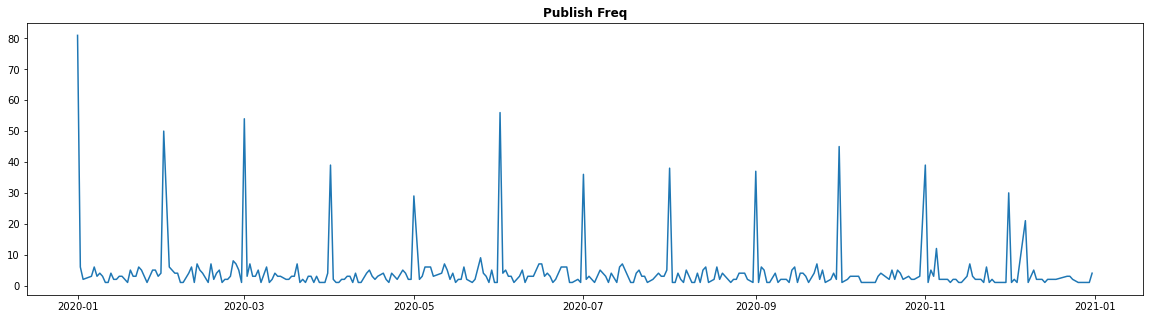

In [15]:
pub_freq = Counter(df_dropped['publication_date'])

plt.figure(figsize=(20, 5))
plt.plot(pub_freq.keys(), pub_freq.values())
plt.title('Publish Freq', fontweight ="bold")
plt.show()